# Linear Model

The linear method makes use of the log backward return (log price difference) to predict foward return.

Training:
1) Ridge regression: on 30 features
2) PC regression: pca on 30 features then perform ols

Feature: 10 stocks, each with 3 backward return (say, 3min, 7min, 10min, see correlation to decide)

Response: 10 stocks' 30min forward return. 

Groups: [1,3,5,9],[2,4,7],[0],[3],[9]

## Data Preparation

In [2]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

log_pr = pd.read_pickle("../data/log_price.df")
volu = pd.read_pickle("../data/volume_usd.df")

In [3]:
def wide_format(df):
    df_= df.reset_index(level=['stock']).sort_index()
    df_ = df_.pivot(columns ='stock')
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_


def get_feature_train(log_pr, volu, x_begin_idx, x_end_idx, y_begin_idx, 
                        grp_idx=None, rm_outlier=False, print_cor=True):
    """
    Input:
    log_pr (pdSeries): train set
    volu (pdSeries): train set
    x_begin_idx (pdIndex): to truncate the NaNs
    grp_idx (dict): key is group idx, value is list of stock idx

    Returns:
    feature_dict (dict): key is group idx, value is a tuple of feature matrix and response
    """

    log_pr_df = log_pr.reset_index().melt(id_vars=['timestamp'])
    log_pr_df.columns = ['timestamp', 'stock', 'log_pr']
    log_pr_df = log_pr_df.set_index(['timestamp', 'stock']).sort_index()

    volu_df = volu.reset_index().melt(id_vars=['timestamp'])
    volu_df.columns = ['timestamp', 'stock', 'volu']
    volu_df = volu_df.set_index(['timestamp', 'stock']).sort_index()

    features = pd.DataFrame(index=log_pr_df.index)
    # log_pr feature
    for i in [10, 20, 30]:
        features['log_pr_{}'.format(i)] = -log_pr_df.groupby(level='stock').log_pr.diff(i)

    std_10 = lambda x: x.rolling(10).std()
    features['log_pr_std_10'] = log_pr_df.groupby(level='stock').log_pr.apply(std_10)

    # volume feature
    log_fn = lambda x: np.log(x+1)
    features['log_volu'] = volu_df.groupby(level='stock').volu.apply(log_fn)

    # stdised volume in 2 hours backward rolling windows
    zscore_fn = lambda x: (x - x.rolling(window=240, min_periods=20).mean()) / x.rolling(window=240, min_periods=20).std()
    features['volu_z_score'] = volu_df.groupby(level='stock').volu.apply(zscore_fn)

    # feature_dropped = features.iloc[x_begin_idx:x_end_idx]
    response = log_pr.diff(30)
    # print(features.shape)
    # print(feature_dropped.shape)
    # print(response_dropped.shape)

    if grp_idx is not None:
        feature_dict = {}
        for key, idx_lis in grp_idx.items():
            feature_df_dropped = wide_format(features.loc[pd.IndexSlice[:,idx_lis],:])
            # transform back to wide format
            feature_dict[key] = (feature_df_dropped.iloc[x_begin_idx:x_end_idx], 
                                            response[idx_lis].iloc[y_begin_idx:])
        return feature_dict
    else:
        # transform back to wide format
        feature_df_dropped = wide_format(features).iloc[x_begin_idx:x_end_idx]
        # feature_df_dropped = feature_df[x_begin_idx:x_end_idx]
    
        if print_cor:
            for i in range(10):
                feature_train_0 = features.xs(i, level='stock')
                print(feature_train_0.corrwith(response[i]))

        return feature_df_dropped, response.iloc[y_begin_idx:]

In [43]:
grp_idx = {0:[1,5,6,8], 1:[0,2,3,4,7,9]}

x_begin_idx = 30
x_end_idx = -30
y_begin_idx = 60

train_split_t = log_pr.index[-87841]
vali_split_t = log_pr.index[-44641]

train_feature_dict = get_feature_train(log_pr[:train_split_t], volu[:train_split_t], x_begin_idx, x_end_idx, y_begin_idx,
                                        grp_idx=None, print_cor=False)

vali_feature_dict = get_feature_train(log_pr[train_split_t:vali_split_t], volu[train_split_t:vali_split_t], x_begin_idx, x_end_idx, y_begin_idx,
                                        grp_idx=None,print_cor=False)

log_pr_10       -0.566440
log_pr_20       -0.807458
log_pr_30       -1.000000
log_pr_std_10    0.294352
log_volu         0.137962
volu_z_score     0.157233
dtype: float64
log_pr_10       -0.564339
log_pr_20       -0.810175
log_pr_30       -1.000000
log_pr_std_10    0.353098
log_volu         0.138490
volu_z_score     0.188771
dtype: float64
log_pr_10       -0.566170
log_pr_20       -0.811186
log_pr_30       -1.000000
log_pr_std_10    0.308044
log_volu         0.087845
volu_z_score     0.168640
dtype: float64
log_pr_10       -0.557927
log_pr_20       -0.798424
log_pr_30       -1.000000
log_pr_std_10    0.320963
log_volu         0.143790
volu_z_score     0.148591
dtype: float64
log_pr_10       -0.540513
log_pr_20       -0.782071
log_pr_30       -1.000000
log_pr_std_10    0.173689
log_volu         0.084277
volu_z_score     0.092012
dtype: float64
log_pr_10       -0.569446
log_pr_20       -0.805383
log_pr_30       -1.000000
log_pr_std_10    0.251723
log_volu         0.137177
volu_z_score   

### Modelling

In [5]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [45]:
# # train
# grp = 0
# xtrain, ytrain = train_feature_dict.get(grp)
# xvali, yvali = vali_feature_dict.get(grp)

AttributeError: 'tuple' object has no attribute 'get'

In [23]:
# xtrain.shape

(177060, 24)

In [24]:
# yvali.shape

(43141, 4)

In [47]:
xtrain, ytrain = train_feature_dict
xvali, yvali = vali_feature_dict

In [53]:
alpha_grid = np.logspace(-4, 1, 15)
n = ytrain.shape[1]
mse = []
for i in range(len(alpha_grid)):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in range(n)},index=yvali.index)
    mse.append(mean_squared_error(yvali, yvali_hat_ridge_a))

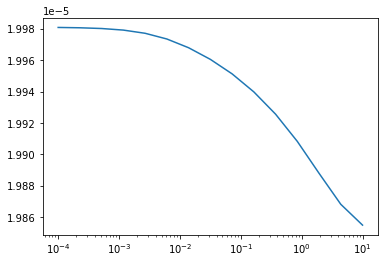

In [55]:
plt.plot(alpha_grid, mse)
plt.xscale('log')

In [56]:
# alpha_grid = np.logspace(-4, 1, 15)
# mse = np.empty(alpha_grid.shape[0])
# for i in range(alpha_grid.shape[0]):
#     rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
#     yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in grp_idx.get(grp)},index=yvali.index)
#     mse[i] = mean_squared_error(yvali,yvali_hat_ridge_a)

# plt.plot(alpha_grid, mse)
# plt.xscale('log')

In [57]:
min_idx = np.argmin(mse)
min_alpha = alpha_grid[min_idx]
print(min_alpha)

10.0


In [59]:
rr = Ridge(alpha=min_alpha).fit(xtrain, ytrain)
# 10-minute-rolling 30-min log-return prediction for validation set
yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in range(n)},index=yvali.index)
# compute pairwise correlation

In [60]:
# rr = Ridge(alpha=min_alpha).fit(xtrain, ytrain)
# # 10-minute-rolling 30-min log-return prediction for validation set
# yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in grp_idx.get(grp)},index=yvali.index)
# # compute pairwise correlation

In [61]:
print(yvali_hat_ridge.shape)
print(yvali.shape)

(43141, 10)
(43141, 10)


In [62]:
print(yvali_hat_ridge.corrwith(yvali))
# print(np.corrcoef(yvali_hat_ridge, yvali))

0    0.050406
1    0.086153
2    0.033008
3    0.005980
4    0.026263
5    0.014712
6    0.018286
7    0.005698
8    0.068812
9    0.051521
dtype: float64


In [63]:
rr = Ridge(alpha=min_alpha).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

In [32]:
# # Data Preparation
# def logr(dta,min):
#     return dta.diff(min,0).dropna()
# x_begin_idx = log_pr.index[30]
# x_end_idx = log_pr.index[-31]
# y_begin_idx = log_pr.index[60]
# group1 = [1,5,6,8]

# # Group 1: {1,5,6,8}
# x = pd.concat((logr(log_pr[group1],10)[x_begin_idx:x_end_idx],
#                 logr(log_pr[group1],20)[x_begin_idx:x_end_idx],
#                 logr(log_pr[group1],30)[x_begin_idx:x_end_idx]),axis=1)
# y = log_pr[group1].diff(30)[y_begin_idx:]
# y = y.set_index(x.index)

# xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
# ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

In [33]:
# # Group 2:
# group2 = [0,2,3,7,9]
# x = pd.concat((logr(log_pr[group2],10)[x_begin_idx:x_end_idx],
#                 logr(log_pr[group2],20)[x_begin_idx:x_end_idx],
#                 logr(log_pr[group2],30)[x_begin_idx:x_end_idx]),axis=1)
# y = log_pr[group2].diff(30)[y_begin_idx:]
# y = y.set_index(x.index)

# xtrain,xvali,xtest = x[:log_pr.index[-87841]],x[log_pr.index[-87840]:log_pr.index[-44641]],x[log_pr.index[-44640]:]
# ytrain,yvali,ytest= y[:log_pr.index[-87841]],y[log_pr.index[-87840]:log_pr.index[-44641]],y[log_pr.index[-44640]:]

### Evaluation

In [34]:
# def get_r_hat(A): 
#     x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
#     x = pd.DataFrame(x).transpose()
#     return rr.predict(x)

In [35]:
def wide_format_test(df):
    df_= df.reset_index()
    df_ = df_.pivot(columns ='index').apply(lambda s: s.dropna().reset_index(drop=True))
    df_.columns = df_.columns.get_level_values(0) + '_' +  [str(x) for x in df_.columns.get_level_values(1)]

    return df_

def get_feature_test(log_pr, volu, grp_idx=None):
    """
    Input: 
    log_pr (pdSeries): 1 day of log pr 
    volu (pdSeries): 1 day of volume

    Output:
    test data frame
    """
    features = pd.DataFrame(index=log_pr.columns)

    # backward return
    # print(-(log_pr.iloc[-1] - log_pr.iloc[-30]).values)
    for i in [10, 20, 30]:
        features['log_pr_{}'.format(i)] = -(log_pr.iloc[-1] - log_pr.iloc[-i]).values
    # backward rolling std
    features['log_pr_std_10'] = log_pr.iloc[-10:].std(0).values
    
    # volume features
    features['log_volu'] = np.log(volu.iloc[-1].values + 1)
    features['volu_z_score'] = ((volu.iloc[-1] - volu.iloc[-240:].mean())/volu.iloc[-240:].std()).values

    if grp_idx is None:
        return wide_format_test(features)
    else:
        df_dict = {}
        for key, idx_lis in grp_idx.items():
            df_dict[key] = wide_format_test(features.loc[idx_lis])
        return df_dict


for now, since we are testing the code, we do not specify for the grp.

In [36]:
def get_r_hat_tune(A, B):
    # grp_idx = {0:[1,5,6,8], 1:[0,2,3,4,7,9]}
    x = get_feature_test(A, B)
    return rr.predict(x)

In [37]:
def evaluate_tune(log_pr_test, volu_test):

    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    # r_fwd = return_true.iloc[1440::10]
    # r_fwd.index = log_pr_test.index[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=log_pr_test.columns, dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat_tune(log_pr_test.loc[(t - dt):t], volu_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat), np.corrcoef(r_fwd_all, r_hat_all)[0,1]

In [38]:
# grp = 0
# log_pr_test = log_pr[grp_idx.get(grp)][vali_split_t:]
# volu_test = volu[grp_idx.get(grp)][vali_split_t:]

In [64]:
log_pr_test = log_pr[vali_split_t:]
volu_test = volu[vali_split_t:]

In [70]:
log_pr_train_vali.iloc[1440::10].shape

(21888, 10)

In [65]:
evaluate_tune(log_pr_test, volu_test)

Time used:  30.062096118927002


(0    0.036005
 1    0.065510
 2    0.026830
 3   -0.003274
 4    0.104775
 5    0.079153
 6    0.020146
 7    0.037946
 8    0.154884
 9    0.078595
 dtype: float64,
 0.04349823016048982)

In [66]:
log_pr_train_vali = log_pr[:vali_split_t]
volu_train_vali = volu[:vali_split_t]

In [67]:
# log_pr_train_vali = log_pr[grp_idx.get(grp)][:vali_split_t]
# volu_train_vali = volu[grp_idx.get(grp)][:vali_split_t]

In [68]:
evaluate_tune(log_pr_train_vali, volu_train_vali)

Time used:  149.79325413703918


(0    0.062874
 1    0.085616
 2    0.058931
 3    0.071948
 4    0.118117
 5    0.066514
 6    0.079066
 7    0.051926
 8    0.097029
 9    0.091457
 dtype: float64,
 0.07541976051201424)

## Ridge Regression

### Model Tuning (MSE and Correlation) 

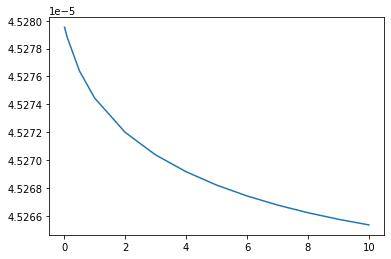

In [71]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

alpha_grid = np.array([0.01,0.05,0.1,0.5,1,2,3,4,5,6,7,8,9,10])
mse = np.empty(alpha_grid.shape[0])
for i in range(alpha_grid.shape[0]):
    rr_a = Ridge(alpha=alpha_grid[i]).fit(xtrain,ytrain)
    yvali_hat_ridge_a = pd.DataFrame(rr_a.predict(xvali),columns={i for i in group2},index=yvali.index)
    mse[i] = mean_squared_error(yvali,yvali_hat_ridge_a)
plt.plot(alpha_grid,mse)

In [72]:
rr = Ridge(alpha=10).fit(xtrain,ytrain)
# 10-minute-rolling 30-min log-return prediction for validation set
yvali_hat_ridge = pd.DataFrame(rr.predict(xvali),columns={i for i in group2},index=yvali.index)
# compute pairwise correlation
print(yvali_hat_ridge.corrwith(yvali[::10]))
#print(np.corrcoef(yvali_hat_ridge[::10],yvali[::10])[0,1])
# Compute mse
#from sklearn.metrics import mean_squared_error
#mean_squared_error(yvali,yvali_hat_ridge)

0    0.062328
2   -0.009268
dtype: float64


### Ridge Test Evaluation

In [96]:
# Refitting the model with train&vali set
rr = Ridge(alpha=12).fit(pd.concat((xtrain,xvali)),pd.concat((ytrain,yvali)))

def get_r_hat(A): 
    x = pd.concat((A.diff(10,0).iloc[-1],A.diff(20,0).iloc[-1],A.diff(30,0).iloc[-1]))
    x = pd.DataFrame(x).transpose()
    return rr.predict(x)

def evaluate(log_pr_test):
    t0 = time.time()
    dt = datetime.timedelta(days=1)

    r_fwd = (log_pr_test.shift(-30) - log_pr_test).iloc[1440::10]
    r_hat = pd.DataFrame(index=log_pr_test.index[1440::10], columns=np.array(group2), dtype=np.float64)

    for t in log_pr_test.index[1440::10]: # compute the predictions every 10 minutes
        # inputs 1 day of log price and volume
        r_hat.loc[t, :] = get_r_hat(log_pr_test.loc[(t - dt):t])
    t_used = time.time() - t0
    print("Time used: ", t_used)

    r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
    r_hat_all = r_hat.iloc[:-3].values.ravel()
    return r_fwd.corrwith(r_hat)#,np.corrcoef(r_fwd_all, r_hat_all)[0,1]

log_pr_test = log_pr[group2][log_pr.index[-44640]:]
evaluate(log_pr_test)

Time used:  13.267999649047852


4    0.057132
7    0.002223
dtype: float64